# fit kde models over the course of odor sampling
To figure out how likely it is for multiple rhythmic relationships to _**coexist**_ in time, or to appear orthogonally as an interneuron shifts its spike timing.


In [29]:
%reset
%load_ext autoreload
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import collections 
import kde_spikephase as kd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns

from kde_spikephase import kde_spikephase_estimator_forarray
from mdl_eval_tools import bayes,kl,logloss
from pprint import pprint
from process_lfps import create_data_segments
from rayleigh_pr import rayleigh_pr
from scipy.signal import hilbert
from scipy import stats
from scipy.stats import sem
from sklearn.model_selection import GridSearchCV 
from sklearn.neighbors import KernelDensity
from tqdm.notebook import tqdm

sns.set(font_scale=1.5,style='whitegrid')

pd.options.display.max_colwidth = 100

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
def get_neuron_cols(df,neuron_expression):
    """df: dataframe containing columns corresponding to neuron spiketimes"""
    
    pattern = re.compile(neuron_expression)
    neuron_cols = []
    for s in df.columns:

        matched = pattern.match(s)
        is_match = bool(matched)

        if is_match:

            neuron_cols.append(matched.string)
    
    return neuron_cols

def get_allowable_lfp_wires(neuron_id,split_on):
    """neuron_id: string, e.g. TETSPK53b
    split_on: string, e.g. 'K', you will use this to exclude the unit letter from neuron_id"""

    #figure out who is the corresponding LFP for this neuron, must be on same tetrode!
    unit_wirenum = neuron.split(split_on)[1]
    unit_wirenum = unit_wirenum[:-1]
    if len(unit_wirenum) > 2:
        unit_wirenum = unit_wirenum[:2]
    allow_wire = [int(unit_wirenum), int(unit_wirenum) + 1, int(unit_wirenum) + 2, int(unit_wirenum) + 3]
    allow_wire = [str(w) for w in allow_wire]
    allow_wire = ['0'+w if int(w)<10 else w for w in allow_wire]
    
    return allow_wire

def get_lfp_cols(df,lfp_expression):
    """df: dataframe containing columns corresponding to neuron spiketimes
    lfp_expression: string, e.g."""
#example lfp_expression =  "TETFP"+allow_wire[0]+"\Z|TETFP"+allow_wire[1]+"\Z|TETFP"+allow_wire[2]+"\Z|TETFP"+allow_wire[3]+"\Z"
        
    pattern = re.compile(lfp_expression)
    lfp_cols = []
    for s in df.columns:

        matched = pattern.match(s)
        is_match = bool(matched)

        if is_match:

            lfp_cols.append(matched.string)

    return lfp_cols

### set up your fitting params


In [31]:
setup_kde = {'n_splits': 7, #7, # 7-fold uses 85% of data to train, 15% to validate
             'grid_size': 1000,
             'bw_narrow': 1/30,
             'bw_wide': 1/0.6,
             'n_bw': 20}

n_splits = setup_kde.get('n_splits')
grid_size = setup_kde.get('grid_size')
bw_narrow = setup_kde.get('bw_narrow')
bw_wide = setup_kde.get('bw_wide')
n_bw = setup_kde.get('n_bw')

### fit models to early and late trial segments
LH2 & LH3 need to have their early window at trial start time, because that is their odor onset
LH8,LH9, and LH16 need to have their early window at 250ms from start time, because that is their odor onset

##### LH2 & LH3

Treat these guys differently because they got the odor on the nosepoke onset, rather than at 250 ms post nosepoke.

In [32]:
savepath = 'over_time_models_ints_250mswins/'

datapath = 'python_spkphase_odorsamp/'
files = os.listdir(datapath)
files = [f for f in files if not f.startswith('.')]
files = [f for f in files if f.startswith('LH02') | f.startswith('LH03')]


rhythms = ['theta', 'beta', 'lowgamma', 'highgamma']
quarter_labels = [1,2,3,4]
#find the columns in the df containing unique neurons' spikes

window_dur = 250 #ms 
for file in tqdm(files, position=0, desc="file", leave=True, colour='cornflowerblue'):

    df = pd.read_csv(os.path.join(datapath,file))
    
    #grab just the time samples corresponding to the odor sampling period
    odorsamp_df = df[df['trial_segment']=='dur']
    df = [] #empty this to save memory
    
    neuron_cols = get_neuron_cols(odorsamp_df,'TETSPK')

    kde_df = [] #initialize the df that will contain all of this file's data
    #get the lfp phases for each rhythm
    
    for quarter in tqdm(quarter_labels,position=1, desc="rhythm", leave=False, colour='lavender'):
        
        #grab just the current quarter/odor set's data
        subq = odorsamp_df[odorsamp_df['quarter_labels'] == quarter]
        
        if np.all(subq['accuracy'] >= .75):
            
            neuron_cols = get_neuron_cols(subq,'TETSPK')
            
            for rhythm in tqdm(rhythms,position=2, desc="rhythm", leave=False, colour='hotpink'):
                
                for neuron in tqdm(neuron_cols, position=3, desc="neuron", leave=False, colour='darkturquoise'):

                    cell_id = file.split('_')[0] + '_' + file.split('_')[1] + '_' + neuron

                    allow_wire = get_allowable_lfp_wires(neuron,'K')

                    #grab the lfps
                    lfp_cols = get_lfp_cols(subq,"TETFP"+allow_wire[0]+"\Z|TETFP"+allow_wire[1]+"\Z|TETFP"+allow_wire[2]+"\Z|TETFP"+allow_wire[3]+"\Z")
                    lfp_name = lfp_cols[0]

                    #create the phase columns using the hilbert transform on the filtered lfp
                    filt_name = lfp_name + 'filt_' + rhythm 

                    filtered = subq[filt_name]
                    analytic_signal = hilbert(filtered)

                    phase_name = lfp_name + 'phase_' + rhythm 
                    subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
                    
                    #get the unique odor position identifiers for each condition
                    condition_labels = subq.groupby(['odor_labels']).sum().index
                    
                    for condition in condition_labels: 
                        
                        odor = condition
                        
                        d = subq[subq['odor_labels']==odor]
                        
                        ntrials = len(set(d['trial_labels']))
                        
                        #trial criterion
                        if ntrials >= 4: 
                           
                            #set up a new column that labels the fitting windows
                            #for each trial
                            blocks_and_trials = d.groupby(['odor_block_labels','trial_labels']).count().index
                            window_one = []
                            window_two = []
                            window_three = []
                            window_four = []
                            window_five = []
                            window_six = []
                            for block_and_trial in blocks_and_trials:

                                block = block_and_trial[0]
                                trial = block_and_trial[1]

                                subtrial = d[(d['odor_block_labels']==block) & (d['trial_labels']==trial)]
#                                 window_nofit0.append(np.repeat('nofit',250))
                                window_one.append(np.repeat('one',window_dur))
                                window_two.append(np.repeat('two',window_dur))
                                window_three.append(np.repeat('three',window_dur))
                                window_four.append(np.repeat('four',window_dur))
                                window_five.append(np.repeat('five',window_dur))
                                window_six.append(np.repeat('six',window_dur+1))

                            all_windows = np.hstack((window_one,
                                                     window_two,
                                                     window_three,
                                                     window_four,
                                                     window_five,
                                                     window_six
                                                    ))
                            flattened = [item for sublist in all_windows for item in sublist]

                            d['fitting_windows'] = flattened

                            fitting_windows = ['one',
                                               'two',
                                               'three',
                                               'four',
                                               'five',
                                               'six'
                                              ]

                            for window in fitting_windows: 

                                subwin = d[d['fitting_windows']==window]
                                #now, grab the spikes and phases to fit the kde curves
                                #grab data
                                spikes = subwin[neuron].values
                                phases = subwin[phase_name].values

                                phi_when_sp = []
                                for s,p in zip(spikes,phases):
                                    if s==1: 
                                        phi_when_sp.append(p)

                                phi_when_sp = np.array(phi_when_sp)

                                #CRITERION: number of spikes must exceed the number of cross val splits for fitting kde
                                if n_splits < sum(spikes):

                                    kde_phaseprob, kde, bw = kde_spikephase_estimator_forarray(phi_when_sp,n_splits,grid_size,bw_narrow,bw_wide,n_bw)

                                    spike_prior = subwin[neuron].sum()/subwin.shape[0]
                                    phase_prior = 1/(2*np.pi)
                                    kde_spikeprob = bayes(kde_phaseprob,
                                                            spike_prior,
                                                            phase_prior
                                      )

                                elif n_splits >= sum(spikes): 
                                    
                                    avg_pspk = sum(spikes)/len(spikes)
                                    kde_spikeprob = np.repeat(avg_pspk,1000)
                                
                                dct = {'cell_id': cell_id,
                                       'quarter_labels': np.repeat(quarter,len(kde_spikeprob)),
                                       'rhythm': np.repeat(rhythm,len(kde_spikeprob)),
                                       'kde_spikeprob': kde_spikeprob,
                                       'kde_phaseprob': kde_phaseprob,
                                       'condition_labels': np.repeat(odor,len(kde_spikeprob)),
                                       'fitting_window': window
                                      }
                                kde_df.append(pd.DataFrame(dct))
        
                
    kde_odor = pd.concat(kde_df)               
    if not os.path.exists(savepath): 
        os.makedirs(savepath)

    savename = file.split('_')[0] + '_' + file.split('_')[1] + '_kde_over_time.csv'
    kde_odor.to_csv(os.path.join(savepath,savename))
        


file:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/1376349295.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

##### LH8,LH9,LH16

In [33]:
savepath = 'over_time_models_ints_250mswins/'

datapath = 'python_spkphase_odorsamp/'
files = os.listdir(datapath)
files = [f for f in files if not f.startswith('.')]
files = [f for f in files if f.startswith('LH08') | f.startswith('LH09') | f.startswith('LH16')]


rhythms = ['theta', 'beta', 'lowgamma', 'highgamma']
quarter_labels = [1,2,3,4]
#find the columns in the df containing unique neurons' spikes

window_dur = 250 #ms 
for file in tqdm(files, position=0, desc="file", leave=True, colour='cornflowerblue'):

    df = pd.read_csv(os.path.join(datapath,file))
    
    #grab just the time samples corresponding to the odor sampling period
    odorsamp_df = df[df['trial_segment']=='dur']
    df = [] #empty this to save memory
    
    neuron_cols = get_neuron_cols(odorsamp_df,'TETSPK')

    kde_df = [] #initialize the df that will contain all of this file's data
    #get the lfp phases for each rhythm
    
    for quarter in tqdm(quarter_labels,position=1, desc="rhythm", leave=False, colour='lavender'):
        
        #grab just the current quarter/odor set's data
        subq = odorsamp_df[odorsamp_df['quarter_labels'] == quarter]
        
        if np.all(subq['accuracy'] >= .75):
            
            neuron_cols = get_neuron_cols(subq,'TETSPK')
            
            for rhythm in tqdm(rhythms,position=2, desc="rhythm", leave=False, colour='hotpink'):
                
                for neuron in tqdm(neuron_cols, position=3, desc="neuron", leave=False, colour='darkturquoise'):

                    cell_id = file.split('_')[0] + '_' + file.split('_')[1] + '_' + neuron

                    allow_wire = get_allowable_lfp_wires(neuron,'K')

                    #grab the lfps
                    lfp_cols = get_lfp_cols(subq,"TETFP"+allow_wire[0]+"\Z|TETFP"+allow_wire[1]+"\Z|TETFP"+allow_wire[2]+"\Z|TETFP"+allow_wire[3]+"\Z")
                    lfp_name = lfp_cols[0]

                    #create the phase columns using the hilbert transform on the filtered lfp
                    filt_name = lfp_name + 'filt_' + rhythm 

                    filtered = subq[filt_name]
                    analytic_signal = hilbert(filtered)

                    phase_name = lfp_name + 'phase_' + rhythm 
                    subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
                    
                    #get the unique odor position identifiers for each condition
                    condition_labels = subq.groupby(['odor_labels']).sum().index
                    
                    for condition in condition_labels: 
                        
                        odor = condition
                        
                        d = subq[subq['odor_labels']==odor]
                        
                        ntrials = len(set(d['trial_labels']))
                        
                        #trial criterion
                        if ntrials >= 4: 
                           
                            #set up a new column that labels the fitting windows
                            #for each trial
                            blocks_and_trials = d.groupby(['odor_block_labels','trial_labels']).count().index
                            window_nofit = []
                            window_one = []
                            window_two = []
                            window_three = []
                            window_four = []
                            window_five = []
                            for block_and_trial in blocks_and_trials:

                                block = block_and_trial[0]
                                trial = block_and_trial[1]

                                subtrial = d[(d['odor_block_labels']==block) & (d['trial_labels']==trial)]
#                                 window_nofit0.append(np.repeat('nofit',250))
                                window_nofit.append(np.repeat('nofit',window_dur))
                                window_one.append(np.repeat('one',window_dur))
                                window_two.append(np.repeat('two',window_dur))
                                window_three.append(np.repeat('three',window_dur))
                                window_four.append(np.repeat('four',window_dur))
                                window_five.append(np.repeat('five',window_dur+1))

                            all_windows = np.hstack((window_nofit,
                                                     window_one,
                                                     window_two,
                                                     window_three,
                                                     window_four,
                                                     window_five
                                                    ))
                            flattened = [item for sublist in all_windows for item in sublist]

                            d['fitting_windows'] = flattened

                            fitting_windows = ['nofit',
                                               'one',
                                               'two',
                                               'three',
                                               'four',
                                               'five'
                                              ]

                            for window in fitting_windows: 

                                subwin = d[d['fitting_windows']==window]
                                #now, grab the spikes and phases to fit the kde curves
                                #grab data
                                spikes = subwin[neuron].values
                                phases = subwin[phase_name].values

                                phi_when_sp = []
                                for s,p in zip(spikes,phases):
                                    if s==1: 
                                        phi_when_sp.append(p)

                                phi_when_sp = np.array(phi_when_sp)

                                #CRITERION: number of spikes must exceed the number of cross val splits for fitting kde
                                if n_splits < sum(spikes):

                                    kde_phaseprob, kde, bw = kde_spikephase_estimator_forarray(phi_when_sp,n_splits,grid_size,bw_narrow,bw_wide,n_bw)

                                    spike_prior = subwin[neuron].sum()/subwin.shape[0]
                                    phase_prior = 1/(2*np.pi)
                                    kde_spikeprob = bayes(kde_phaseprob,
                                                            spike_prior,
                                                            phase_prior
                                      )

                                elif n_splits >= sum(spikes): 
                                    
                                    avg_pspk = sum(spikes)/len(spikes)
                                    kde_spikeprob = np.repeat(avg_pspk,1000)
                                    
                                dct = {'cell_id': cell_id,
                                       'quarter_labels': np.repeat(quarter,len(kde_spikeprob)),
                                       'rhythm': np.repeat(rhythm,len(kde_spikeprob)),
                                       'kde_spikeprob': kde_spikeprob,
                                       'kde_phaseprob': kde_phaseprob,
                                       'condition_labels': np.repeat(odor,len(kde_spikeprob)),
                                       'fitting_window': window
                                      }
                                kde_df.append(pd.DataFrame(dct))
        
                
    kde_odor = pd.concat(kde_df)               
    if not os.path.exists(savepath): 
        os.makedirs(savepath)

    savename = file.split('_')[0] + '_' + file.split('_')[1] + '_kde_over_time.csv'
    kde_odor.to_csv(os.path.join(savepath,savename))
        


file:   0%|          | 0/14 [00:00<?, ?it/s]

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

rhythm:   0%|          | 0/4 [00:00<?, ?it/s]

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

neuron:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subq[phase_name] = np.arctan2(analytic_signal.imag,filtered)
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['fitting_windows'] = flattened
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3936189280.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

## now, get the sumklds for each phase model, for each window


In [34]:
n_splits = 7
rhythms = ['theta','lowgamma','highgamma']

datapath = 'over_time_models_ints_250mswins/'
files = os.listdir(datapath)
files = [f for f in files if not f.startswith('.')]


sumkld_df = [] #initialize the df that will contain all the files' data

for file in tqdm(files,position=0,colour='cornflowerblue'): 
    
    kdedf = pd.read_csv(os.path.join(datapath,file))

    neurons = list(set(kdedf['cell_id']))
    
    for neuron in neurons: 
        
        cell_id = neuron
        subneuron = kdedf[kdedf['cell_id']==cell_id]

        conditions = list(set(subneuron['condition_labels']))

        for condition in conditions: 

            subcond = subneuron[subneuron['condition_labels']==condition]

            for rhythm in rhythms: 

                subrh = subcond[subcond['rhythm']==rhythm]

                if (file.startswith('LH02')) | (file.startswith('LH03')): 

                    windows = ['one','two','three','four','five','six']

                elif (file.startswith('LH08')) | (file.startswith('LH09')) | (file.startswith('LH16')): 

                    windows = ['one','two','three','four','five']

                for window in windows: 

                    subwin = subrh[subrh['fitting_window']==window]


                    uni_pspk = np.repeat(np.mean(subwin['kde_spikeprob']),subwin.shape[0])


                    sumkl = np.sum(kl(subwin['kde_spikeprob'].values,uni_pspk))
                    if np.isnan(sumkl): 
                        sumkl = 0

                    cell_id = list(set(subwin['cell_id'].values))[0]
                    quarter = list(set(subwin['quarter_labels']))[0]

                    sumkld = {'cell_id': cell_id,
                              'rhythm': rhythm,
                              'quarter_labels': [quarter],
                              'condition_labels': [condition],
                              'fitting_window': [window],
                              'sumkld': [sumkl]
                             }


                    sumkld_df.append(pd.DataFrame(sumkld))

sumkld_df = pd.concat(sumkld_df)
                
                
                


  0%|          | 0/18 [00:00<?, ?it/s]

/Users/pamelariviere/Desktop/rhythmic_clusters/rhythmic_clusters-main/mdl_eval_tools.py:13: RuntimeWarning: invalid value encountered in double_scalars
  kls.append(p1*np.log2(p1/p2)+(1-p1)*np.log2((1-p1)/(1-p2)))
/Users/pamelariviere/Desktop/rhythmic_clusters/rhythmic_clusters-main/mdl_eval_tools.py:13: RuntimeWarning: invalid value encountered in double_scalars
  kls.append(p1*np.log2(p1/p2)+(1-p1)*np.log2((1-p1)/(1-p2)))
/Users/pamelariviere/Desktop/rhythmic_clusters/rhythmic_clusters-main/mdl_eval_tools.py:13: RuntimeWarning: invalid value encountered in double_scalars
  kls.append(p1*np.log2(p1/p2)+(1-p1)*np.log2((1-p1)/(1-p2)))


### Figure 3C (entrainment time courses)
example cell entrainment (we show trajectories for odors 7 & 8 in the paper)

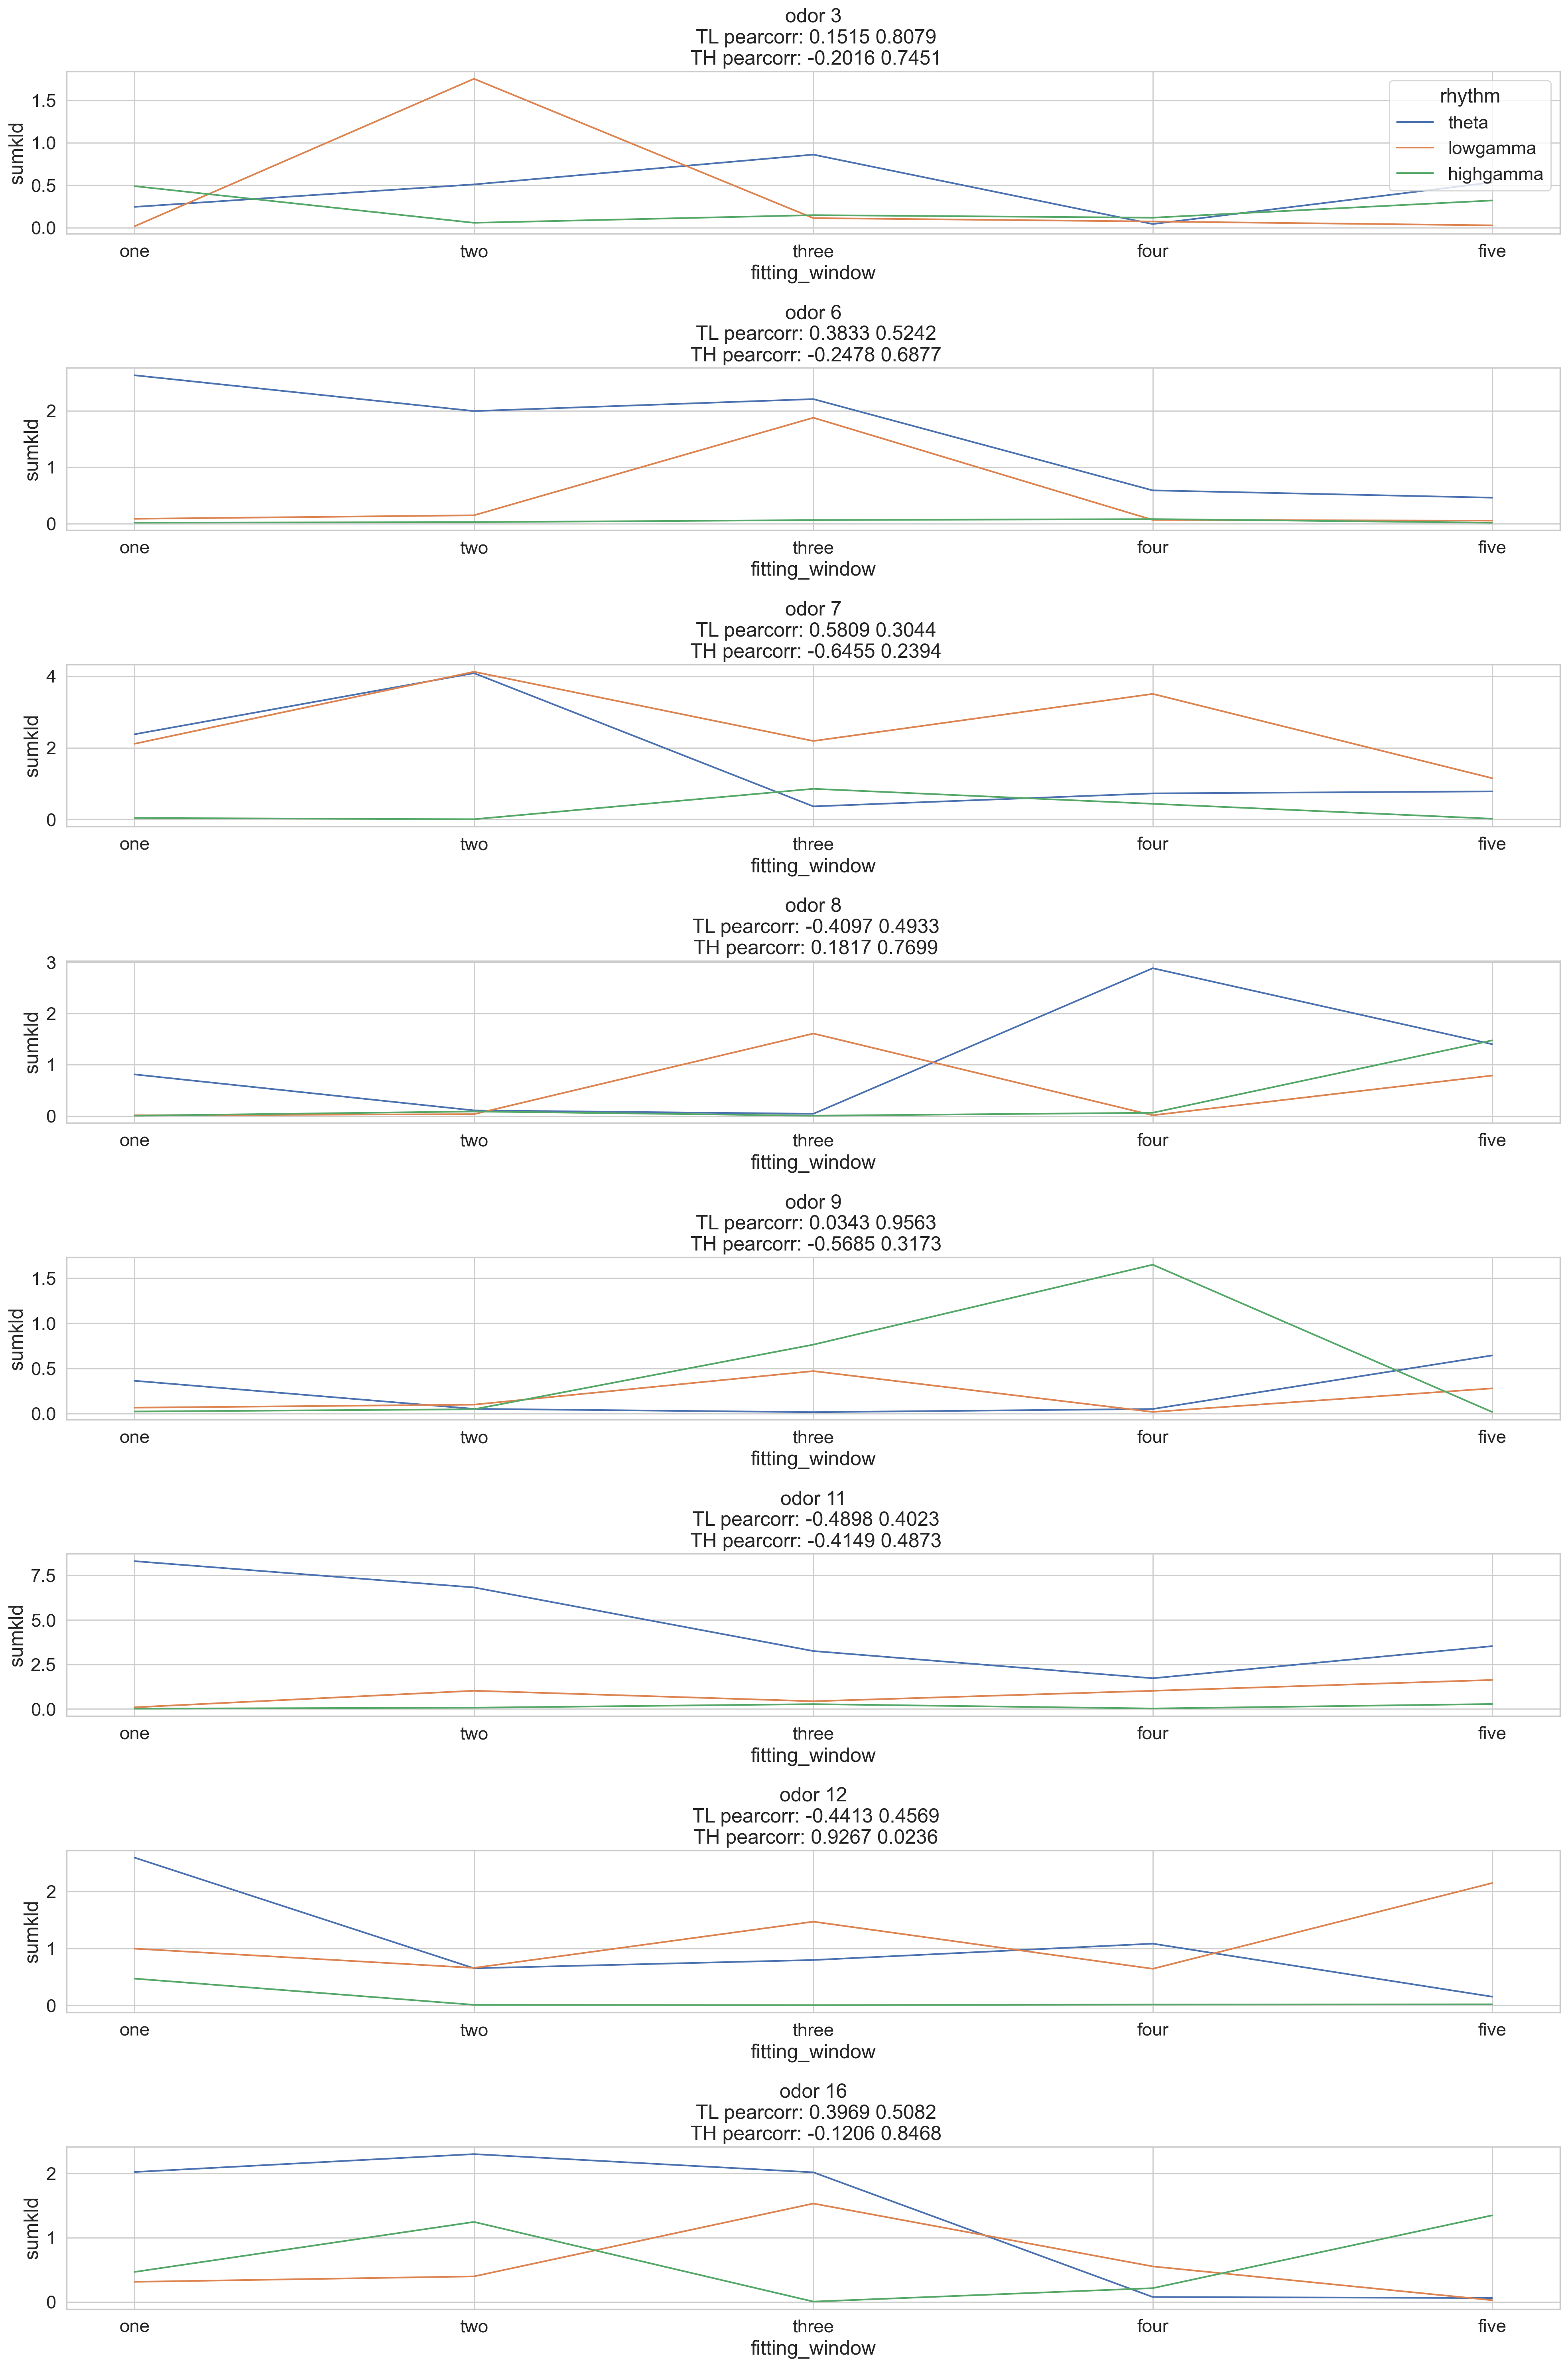

In [35]:
cell_id = 'LH16_D10_TETSPK33a'

subcell = sumkld_df[sumkld_df['cell_id']==cell_id]
conditions = list(set(subcell['condition_labels']))
nconds = len(conditions)

fig,ax = plt.subplots(nconds,1,figsize=(20,30))

rhythms = ['theta','lowgamma','highgamma']

for c,condition in enumerate(conditions): 

    subcond = subcell[subcell['condition_labels']==condition]
    
    if c==0: 
        
        should_legend_be_on = 'auto'
        
    else: 
        
        should_legend_be_on = False
        
    theta_sumkls = subcond[subcond['rhythm']=='theta']['sumkld'].values
    lowgamma_sumkls = subcond[subcond['rhythm']=='lowgamma']['sumkld'].values
    highgamma_sumkls = subcond[subcond['rhythm']=='highgamma']['sumkld'].values

    TL_pear_r, TL_pear_pval = stats.pearsonr(theta_sumkls,lowgamma_sumkls)
    TH_pear_r, TH_pear_pval = stats.pearsonr(theta_sumkls,highgamma_sumkls)
        
    sns.lineplot(data=subcond.reset_index(),
                 x = 'fitting_window',
                 y = 'sumkld',
                 hue= 'rhythm',
                 ax=ax[c],
                 legend=should_legend_be_on
            ).set_title('odor '+str(condition) + '\n TL pearcorr: ' + str(round(TL_pear_r,4))+ ' ' + str(round(TL_pear_pval,4)) + '\n TH pearcorr: '+ str(round(TH_pear_r,4))+ ' ' + str(round(TH_pear_pval,4)))
    
    

   
    
fig.tight_layout()

figpath='figures_odor/'
if not os.path.exists(figpath): 
    os.makedirs(figpath)
    
fig.savefig(os.path.join(figpath,'example_cell_sumkls_over_time_'+cell_id+'.pdf'))

### Figure 3C (window phase models)

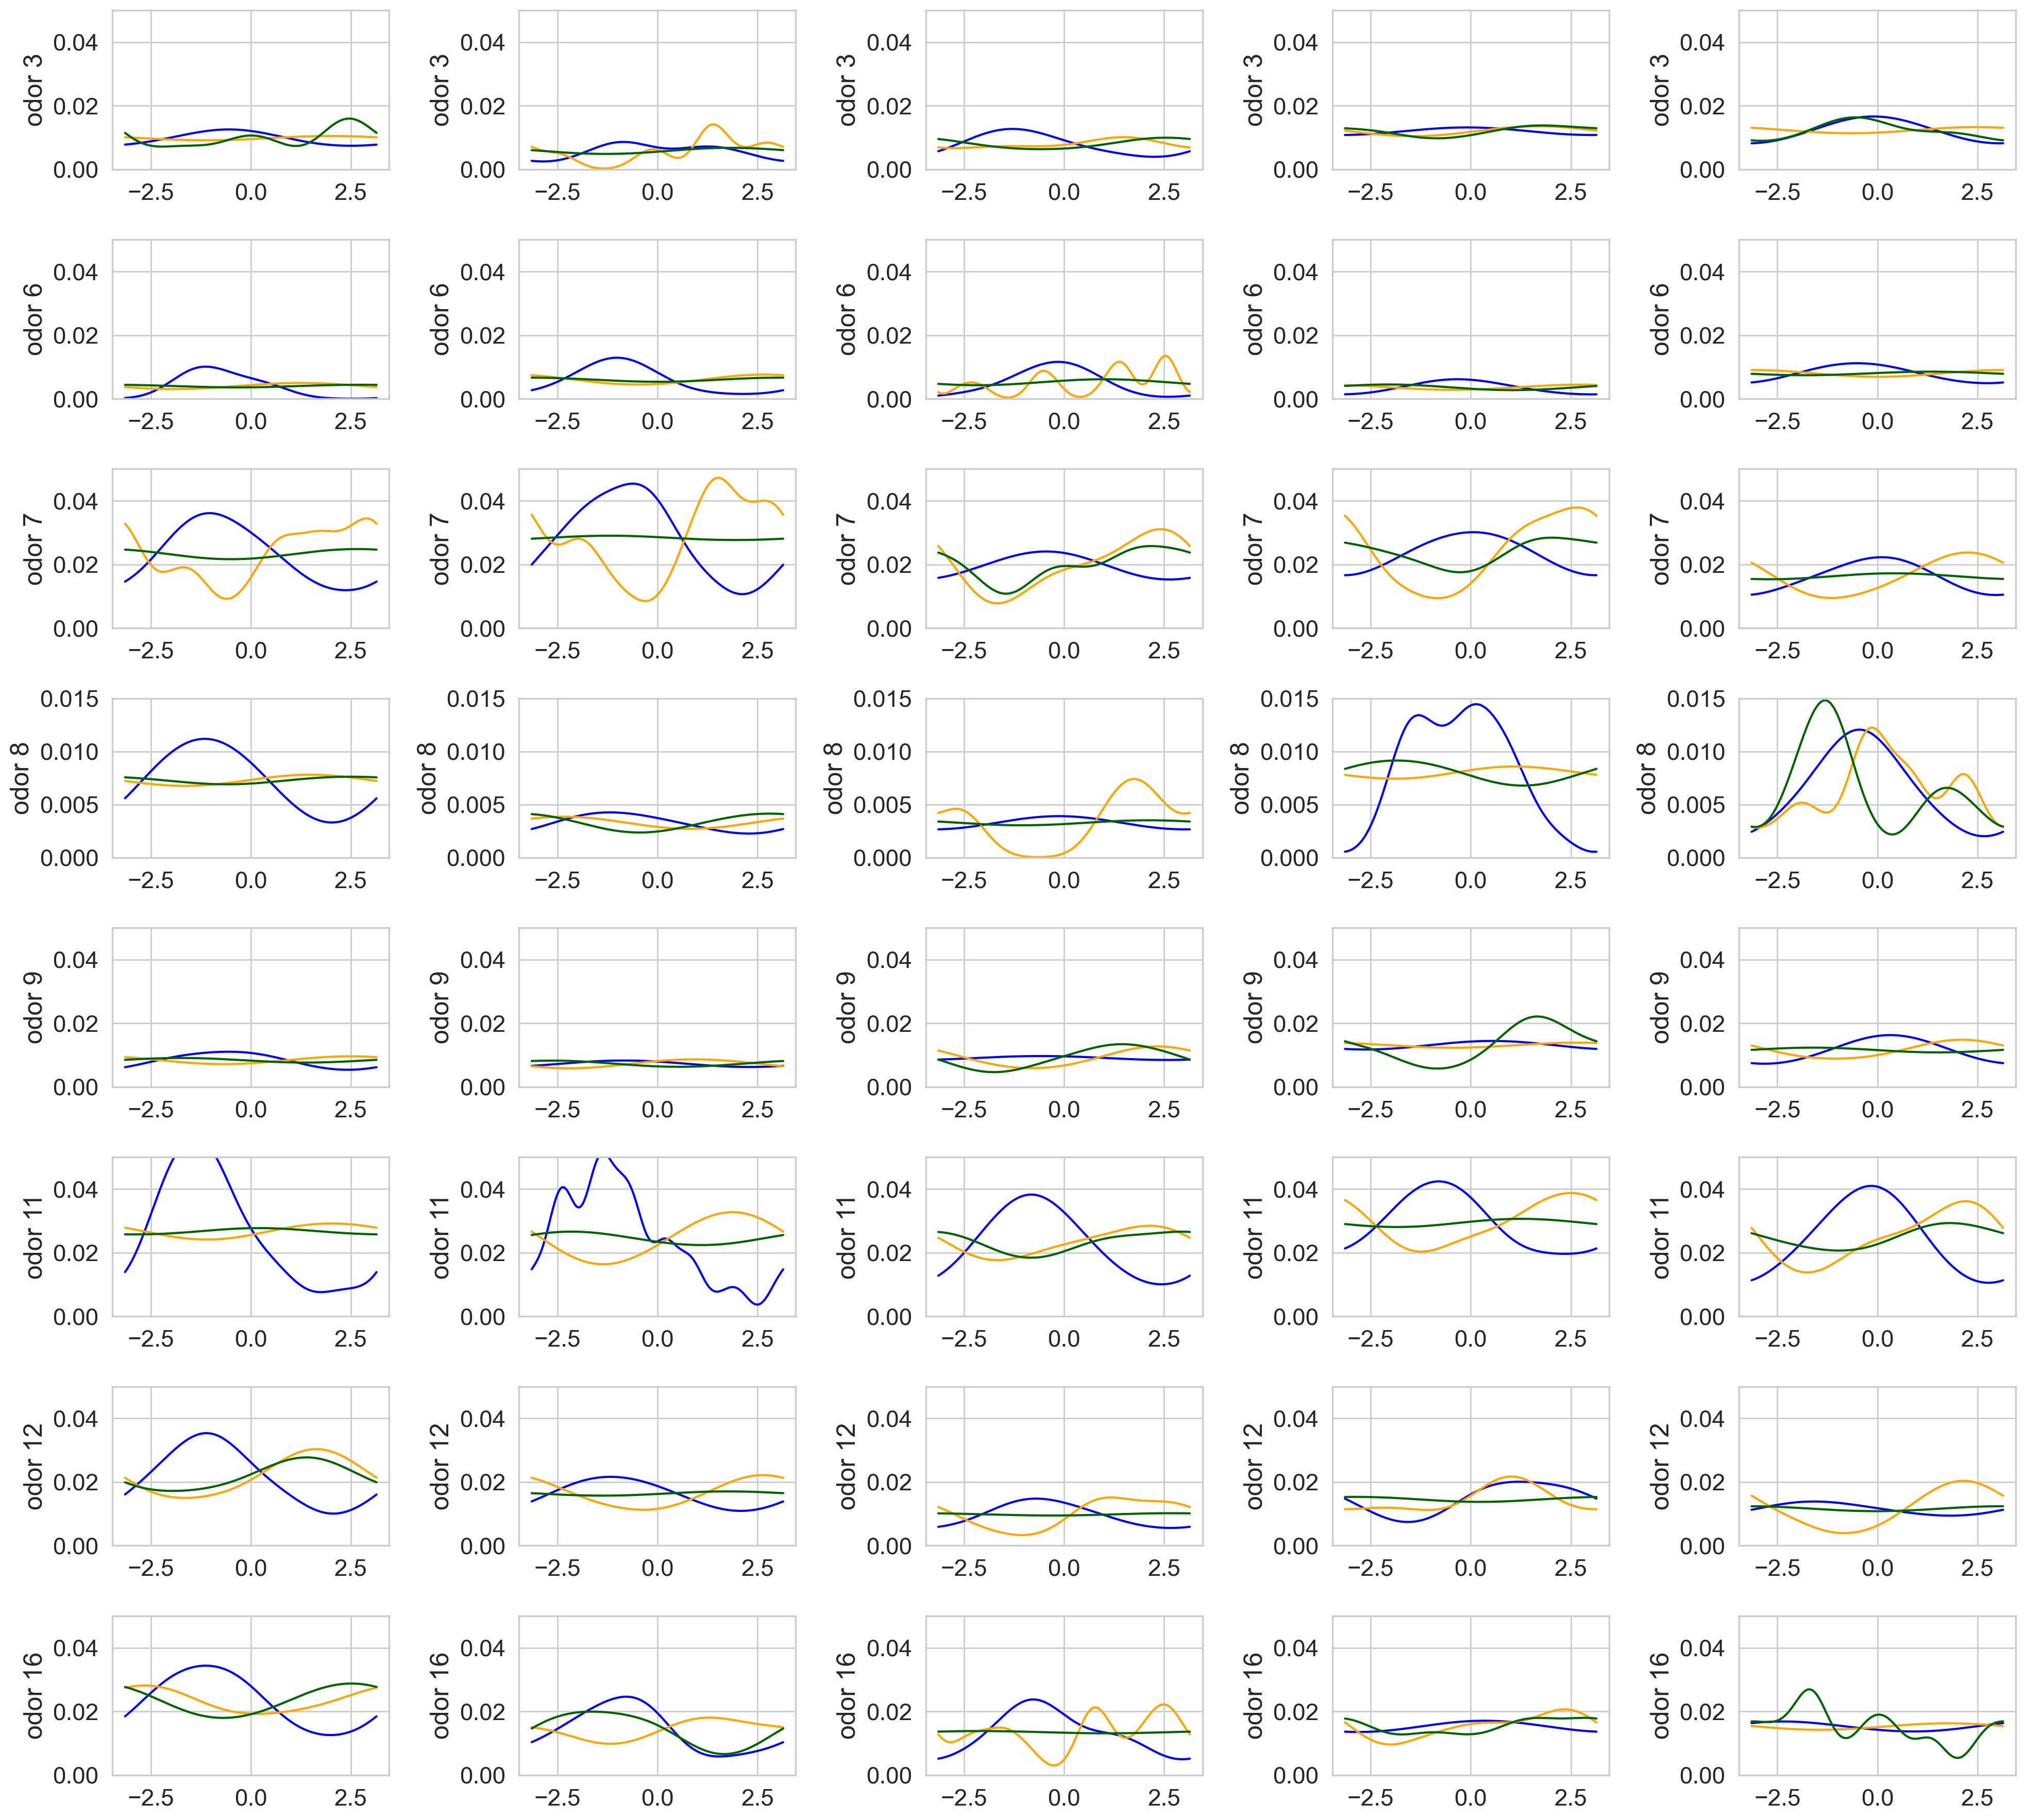

In [36]:
file = cell_id.split('TET')[0]+'kde_over_time.csv'

kdedf = pd.read_csv(os.path.join(datapath,file))

conditions = list(set(kdedf['condition_labels']))
nconds = len(conditions)

if file.startswith('LH02') | file.startswith('LH03'): 
        
    windows = ['one','two','three','four','five','six']
        
else: 
        
    windows = ['one','two','three','four','five']

                   
fig,ax = plt.subplots(nconds,len(windows),figsize=(20,round(len(windows)*3.7)))

rhythms = ['theta','lowgamma','highgamma']

subcell = kdedf[kdedf['cell_id']==cell_id]

for c,condition in enumerate(conditions): 

    subcond = subcell[subcell['condition_labels']==condition]
    
    if c==0: 
        
        should_legend_be_on = 'auto'
        
    else: 
        
        should_legend_be_on = False
    
    for w,window in enumerate(windows): 
        
        subwin = subcond[subcond['fitting_window']==window]
        
        subtheta = subwin[subwin['rhythm']=='theta']
        sublowgamma = subwin[subwin['rhythm']=='lowgamma']
        subhighgamma = subwin[subwin['rhythm']=='highgamma']

        sns.lineplot(data=subtheta,
                     x = np.linspace(-np.pi,np.pi,1000),
                     y = 'kde_spikeprob',
                     color = 'blue',
                     ax=ax[c][w],
                     legend=should_legend_be_on
                ) 
        
        sns.lineplot(data=sublowgamma,
                     x = np.linspace(-np.pi,np.pi,1000),
                     y = 'kde_spikeprob',
                     color = 'orange',
                     ax=ax[c][w],
                     legend=should_legend_be_on
                ) 
        
        sns.lineplot(data=subhighgamma,
                     x = np.linspace(-np.pi,np.pi,1000),
                     y = 'kde_spikeprob',
                     color = 'darkgreen',
                     ax=ax[c][w],
                     legend=should_legend_be_on
                ).set_ylabel('odor '+ str(condition)) 
        
    for a in ax[c]: 
        
        a.set_ylim(0,0.05)
        
    for a in ax[2]:
        
        a.set_ylim(0,0.05)
        
    for a in ax[3]:
        
        a.set_ylim(0,0.015)
        
fig.tight_layout()     

figpath='figures_odor/'
if not os.path.exists(figpath): 
    os.makedirs(figpath)
    
fig.savefig(os.path.join(figpath,'example_cell_models_over_time_'+cell_id+'.pdf'))

figure out which side (or sides) of the maze these two odors took place in for this rat. Odor ports 3 & 4 are on the right side

In [37]:
ogpath = 'python_spkphase_odorsamp/'
file = cell_id.split('TET')[0] + 'correct.csv'

df = pd.read_csv(os.path.join(ogpath,file))


In [38]:
print(set(df[df['odor_labels'] == 7]['pos_labels']))
print(set(df[df['odor_labels'] == 8]['pos_labels']))

{1, 2}
{3, 4}


### pearson correlations
first, add cluster labels to each interneuron, so you can do the Pearson correlations only for spike trains that were in the entrained categories (rather than the insensitive categories)

you would have created the loaded file in notebook `step2_visualize_clusters_odorsamp.ipynb`.

In [39]:
clust_id_df = pd.read_csv('cluster_ids_theta_lowgamma_highgamma.csv')

now merge the sum kld df with the cluster labels df!

In [40]:
sumkld_clust_df = sumkld_df.merge(clust_id_df,on=['cell_id','condition_labels'])


In [41]:
sumkld_clust_df

,cell_id,rhythm,quarter_labels,condition_labels,fitting_window,sumkld,Unnamed: 0,spktrn_ind_labels,theta_clust_id,lowgamma_clust_id,highgamma_clust_id
0,LH09_D04_TETSPK13a,theta,2,6,one,2.497577,62,131,0,3,2
1,LH09_D04_TETSPK13a,theta,2,6,two,3.393950,62,131,0,3,2
2,LH09_D04_TETSPK13a,theta,2,6,three,4.052497,62,131,0,3,2
3,LH09_D04_TETSPK13a,theta,2,6,four,3.391642,62,131,0,3,2
4,LH09_D04_TETSPK13a,theta,2,6,five,2.293972,62,131,0,3,2
...,...,...,...,...,...,...,...,...,...,...,...
3175,LH16_D33_TETSPK33j,highgamma,2,16,one,1.473581,57,14,0,3,0
3176,LH16_D33_TETSPK33j,highgamma,2,16,two,0.185572,57,14,0,3,0
3177,LH16_D33_TETSPK33j,highgamma,2,16,three,0.226892,57,14,0,3,0
3178,LH16_D33_TETSPK33j,highgamma,2,16,four,0.088150,57,14,0,3,0


#### gather up all the spike trains' correlations
for theta-low gamma, and theta-high gamma sum kld correlations separately

In [42]:
cells = list(set(sumkld_clust_df['cell_id']))
rhythms = ['theta','lowgamma','highgamma']

gather_peardfs = []
for cell_id in cells: 
    
    subcell = sumkld_clust_df[sumkld_clust_df['cell_id']==cell_id]
    
    conditions = list(set(subcell['condition_labels']))
    nconds = len(conditions)

    for c,condition in enumerate(conditions): 

        subcond = subcell[subcell['condition_labels']==condition]
        
        if (cell_id.startswith('LH02')) | (cell_id.startswith('LH03')): 
            
            subcond = subcond[subcond['fitting_window'] != 'six']
            
        else: 
            
            subcond = subcond[subcond['fitting_window'] != 'nofit']

        theta_sumkls = subcond[subcond['rhythm']=='theta']['sumkld'].values
        lowgamma_sumkls = subcond[subcond['rhythm']=='lowgamma']['sumkld'].values
        highgamma_sumkls = subcond[subcond['rhythm']=='highgamma']['sumkld'].values

        TL_pear_r, TL_pear_pval = stats.pearsonr(theta_sumkls,lowgamma_sumkls)
        TH_pear_r, TH_pear_pval = stats.pearsonr(theta_sumkls,highgamma_sumkls)
        LH_pear_r, LH_pear_pval = stats.pearsonr(lowgamma_sumkls,highgamma_sumkls)
        
        theta_id = subcond['theta_clust_id'].iloc[0]
        lowgamma_id = subcond['lowgamma_clust_id'].iloc[0]
        highgamma_id = subcond['highgamma_clust_id'].iloc[0]
        
        d = {'cell_id': cell_id,
             'condition_labels': [condition],
             'TL_pearson_r': [TL_pear_r],
             'TL_pearson_p': [TL_pear_pval],
             'TH_pearson_r': [TH_pear_r],
             'TH_pearson_p': [TH_pear_pval],
             'LH_pearson_r': [LH_pear_r],
             'LH_pearson_pval': [LH_pear_pval],
             'theta_clust_id': [theta_id],
             'lowgamma_clust_id': [lowgamma_id],
             'highgamma_clust_id': [highgamma_id]
            }
        
        gather_peardfs.append(pd.DataFrame(d))
        
pear_df = pd.concat(gather_peardfs)
        

In [43]:
# drop LH03_D18_TETSPK49b, bc it's all zeros, there is no spiking at all -- this is the 
# neuron id that we drop from odor samp epochs, but that we keep for approach epoch analyses
pear_df = pear_df[pear_df['cell_id'] != 'LH03_D18_TETSPK49b']

#### make histograms that drop any comparisons between rhythm-insensitive cells
we don't want to just get pearson correlation coefficients between spike trains with no entrainment to the rhythms being considered--this is just way less meaningful.

In [44]:
pear_df_strong_TL = pear_df[(pear_df['theta_clust_id'] != 3) & (pear_df['lowgamma_clust_id'] != 3)]
pear_df_strong_TH = pear_df[(pear_df['theta_clust_id'] != 3) & (pear_df['highgamma_clust_id'] != 3)]
pear_df_strong_LH = pear_df[(pear_df['lowgamma_clust_id'] != 3) & (pear_df['highgamma_clust_id'] != 2)]

### Figure 3D

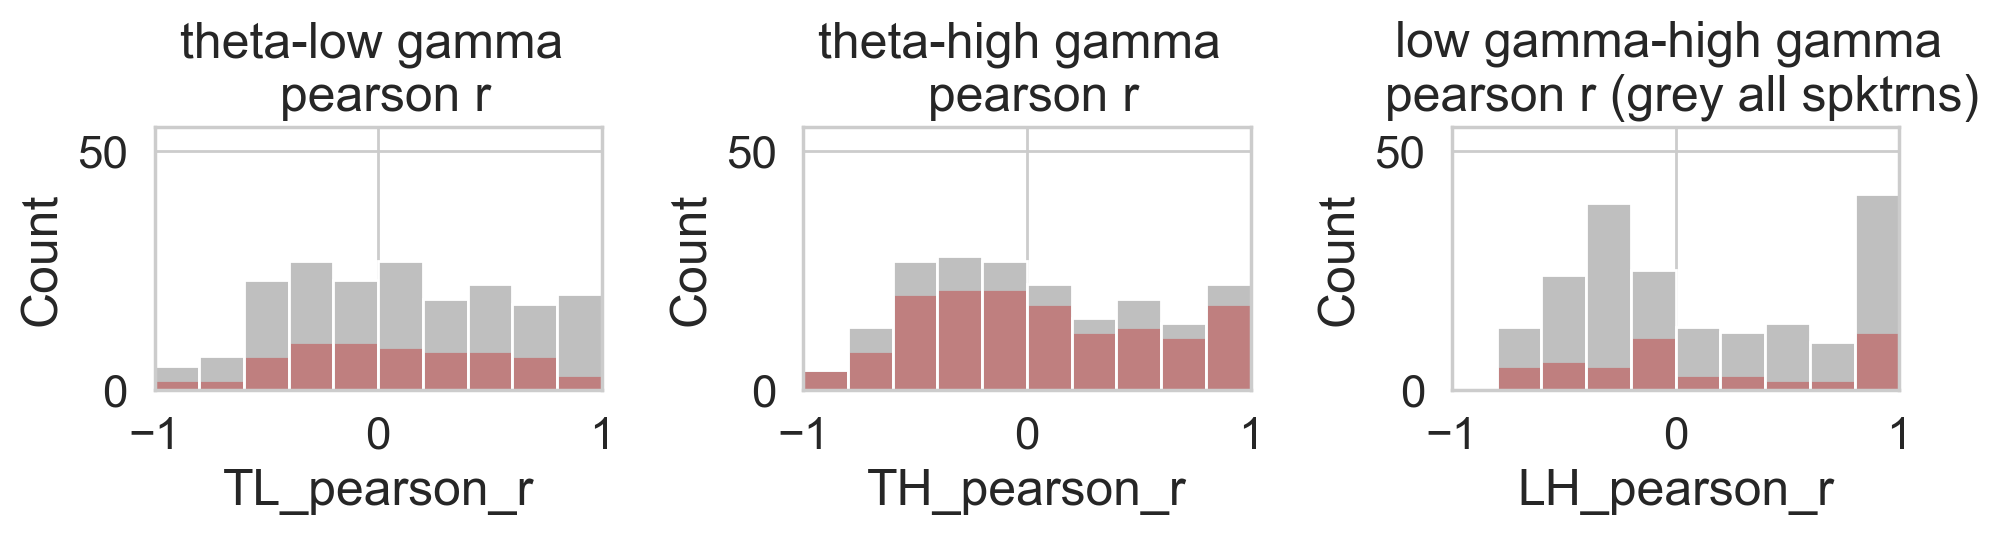

In [45]:
fig,ax = plt.subplots(1,3,figsize=(10,3))

binwidth = 0.2

sns.histplot(pear_df_strong_TL['TL_pearson_r'],
             color = 'red', 
             alpha=0.5,
             binwidth=binwidth,
             binrange=(-1,1),
             ax=ax[0]).set_title('theta-low gamma \n pearson r')

sns.histplot(pear_df['TL_pearson_r'],
             color = 'grey', 
             alpha=0.5,
             binwidth=binwidth,
             binrange=(-1,1),
             ax=ax[0]).set_title('theta-low gamma \n pearson r')

sns.histplot(pear_df_strong_TH['TH_pearson_r'],
             color = 'red', 
             alpha=0.5,
             binwidth=binwidth,
             binrange=(-1,1),
             ax=ax[1]).set_title('theta-high gamma \n pearson r')

sns.histplot(pear_df['TH_pearson_r'],
             color = 'grey', 
             alpha=0.5,
             binwidth=binwidth,
             binrange=(-1,1),
             ax=ax[1]).set_title('theta-high gamma \n pearson r')


sns.histplot(pear_df_strong_LH['LH_pearson_r'],
             color = 'red', 
             alpha=0.5,
             binwidth=binwidth,
             binrange=(-1,1),
             ax=ax[2]).set_title('low gamma-high gamma \n pearson r')

sns.histplot(pear_df['LH_pearson_r'],
             color = 'grey', 
             alpha=0.5,
             binwidth=binwidth,
             binrange=(-1,1),
             ax=ax[2]).set_title('low gamma-high gamma \n pearson r (grey all spktrns)')
for a in ax: 
    
    a.set_xlim(-1,1)
    a.set_ylim(0,55)
    


fig.tight_layout()

figpath='figures_odor/'
if not os.path.exists(figpath): 
    os.makedirs(figpath)
    
fig.savefig(os.path.join(figpath,'sumkld_rhythmic_pair_correlations_over_time.pdf'))

#### now, count how many correlation types each cell experienced
across their available spike trains. To do this, you'll first have to categorize each correlation into negatively correlated (less than -0.5, middling to no correlation, and greater than 0.5). 

In [46]:
pos_thresh = 0.5
neg_thresh = -pos_thresh

pear_df_strong_TL['TL_pearson_corrtype'] = ['poscorr' if (i > pos_thresh) else 'negcorr' if (i < neg_thresh) else 'nocorr' for i in pear_df_strong_TL['TL_pearson_r'].values]
pear_df_strong_TH['TH_pearson_corrtype'] = ['poscorr' if (i > pos_thresh) else 'negcorr' if (i < neg_thresh) else 'nocorr' for i in pear_df_strong_TH['TH_pearson_r'].values]
pear_df_strong_LH['LH_pearson_corrtype'] = ['poscorr' if (i > pos_thresh) else 'negcorr' if (i < neg_thresh) else 'nocorr' for i in pear_df_strong_LH['LH_pearson_r'].values]



/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3860223930.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pear_df_strong_TL['TL_pearson_corrtype'] = ['poscorr' if (i > pos_thresh) else 'negcorr' if (i < neg_thresh) else 'nocorr' for i in pear_df_strong_TL['TL_pearson_r'].values]
/var/folders/95/7z0h1t9s5tx7km1h1t7t08kw0000gn/T/ipykernel_1739/3860223930.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pear_df_strong_TH['TH_pearson_corrtype'] = ['poscorr' if (i > pos_thresh) else 'negc

##### theta-low gamma

In [47]:
set(pear_df_strong_TL['cell_id']),len(set(pear_df_strong_TL['cell_id']))

({'LH02_D11_TETSPK05a',
  'LH02_D14_TETSPK13b',
  'LH03_D18_TETSPK09f',
  'LH03_D18_TETSPK85k',
  'LH08_D32_TETSPK09c',
  'LH08_D32_TETSPK53n',
  'LH09_D09_TETSPK21b',
  'LH09_D10_TETSPK53b',
  'LH09_D14_TETSPK13b',
  'LH16_D09_TETSPK29g',
  'LH16_D10_TETSPK21k',
  'LH16_D10_TETSPK33a',
  'LH16_D22_TETSPK25f',
  'LH16_D22_TETSPK29g',
  'LH16_D25_TETSPK33m',
  'LH16_D25_TETSPK37b',
  'LH16_D29_TETSPK09a',
  'LH16_D29_TETSPK53c',
  'LH16_D33_TETSPK33j',
  'LH16_D42_TETSPK49m'},
 20)

In [48]:
for cell_id in cells: 
    
    subcell = pear_df_strong_TL[pear_df_strong_TL['cell_id']==cell_id]
    print('TL',cell_id, set(subcell['TL_pearson_corrtype']))

TL LH08_D32_TETSPK09c {'poscorr', 'nocorr'}
TL LH09_D14_TETSPK13b {'poscorr', 'nocorr'}
TL LH09_D09_TETSPK21b {'nocorr'}
TL LH16_D25_TETSPK37b {'nocorr'}
TL LH16_D10_TETSPK21k {'poscorr', 'nocorr'}
TL LH16_D22_TETSPK29g {'nocorr'}
TL LH09_D15_TETSPK13b set()
TL LH03_D20_TETSPK61a set()
TL LH16_D25_TETSPK33m {'nocorr'}
TL LH03_D18_TETSPK85k {'nocorr'}
TL LH02_D14_TETSPK13b {'poscorr'}
TL LH02_D14_TETSPK41d set()
TL LH16_D29_TETSPK09a {'nocorr', 'negcorr'}
TL LH16_D10_TETSPK33a {'poscorr', 'nocorr'}
TL LH16_D42_TETSPK37f set()
TL LH16_D29_TETSPK53c {'poscorr', 'nocorr'}
TL LH09_D04_TETSPK13a set()
TL LH16_D22_TETSPK25f {'nocorr'}
TL LH08_D32_TETSPK53n {'poscorr', 'nocorr'}
TL LH02_D11_TETSPK05a {'nocorr', 'negcorr'}
TL LH03_D18_TETSPK09f {'poscorr'}
TL LH16_D09_TETSPK21j set()
TL LH09_D10_TETSPK53b {'poscorr', 'nocorr', 'negcorr'}
TL LH02_D14_TETSPK13a set()
TL LH16_D09_TETSPK29g {'poscorr', 'nocorr'}
TL LH08_D28_TETSPK29c set()
TL LH16_D22_TETSPK09c set()
TL LH16_D42_TETSPK49m {'poscorr

##### theta-high gamma

In [49]:
set(pear_df_strong_TH['cell_id']),len(set(pear_df_strong_TH['cell_id']))

({'LH02_D11_TETSPK05a',
  'LH02_D14_TETSPK13a',
  'LH02_D14_TETSPK13b',
  'LH02_D14_TETSPK41d',
  'LH03_D18_TETSPK09f',
  'LH03_D18_TETSPK85k',
  'LH03_D20_TETSPK61a',
  'LH08_D28_TETSPK29c',
  'LH08_D32_TETSPK09c',
  'LH08_D32_TETSPK21c',
  'LH08_D32_TETSPK53n',
  'LH09_D04_TETSPK13a',
  'LH09_D09_TETSPK21b',
  'LH09_D10_TETSPK53b',
  'LH09_D14_TETSPK13b',
  'LH09_D15_TETSPK13b',
  'LH16_D09_TETSPK21j',
  'LH16_D09_TETSPK29g',
  'LH16_D10_TETSPK21k',
  'LH16_D10_TETSPK33a',
  'LH16_D22_TETSPK25f',
  'LH16_D22_TETSPK29g',
  'LH16_D25_TETSPK33m',
  'LH16_D25_TETSPK37b',
  'LH16_D29_TETSPK09a',
  'LH16_D29_TETSPK53c',
  'LH16_D33_TETSPK33j',
  'LH16_D42_TETSPK37f',
  'LH16_D42_TETSPK49m'},
 29)

In [50]:
for cell_id in cells: 
    
    subcell = pear_df_strong_TH[pear_df_strong_TH['cell_id']==cell_id]
    print('TH',cell_id, set(subcell['TH_pearson_corrtype']))

TH LH08_D32_TETSPK09c {'poscorr', 'nocorr'}
TH LH09_D14_TETSPK13b {'poscorr', 'nocorr'}
TH LH09_D09_TETSPK21b {'poscorr', 'nocorr'}
TH LH16_D25_TETSPK37b {'poscorr', 'nocorr', 'negcorr'}
TH LH16_D10_TETSPK21k {'poscorr', 'nocorr', 'negcorr'}
TH LH16_D22_TETSPK29g {'poscorr', 'nocorr', 'negcorr'}
TH LH09_D15_TETSPK13b {'nocorr', 'negcorr'}
TH LH03_D20_TETSPK61a {'poscorr', 'nocorr'}
TH LH16_D25_TETSPK33m {'poscorr', 'nocorr'}
TH LH03_D18_TETSPK85k {'poscorr', 'nocorr', 'negcorr'}
TH LH02_D14_TETSPK13b {'nocorr'}
TH LH02_D14_TETSPK41d {'nocorr'}
TH LH16_D29_TETSPK09a {'poscorr', 'nocorr', 'negcorr'}
TH LH16_D10_TETSPK33a {'poscorr', 'nocorr', 'negcorr'}
TH LH16_D42_TETSPK37f {'poscorr', 'nocorr'}
TH LH16_D29_TETSPK53c {'nocorr', 'negcorr'}
TH LH09_D04_TETSPK13a {'poscorr', 'nocorr', 'negcorr'}
TH LH16_D22_TETSPK25f {'nocorr', 'negcorr'}
TH LH08_D32_TETSPK53n {'poscorr', 'nocorr'}
TH LH02_D11_TETSPK05a {'nocorr', 'negcorr'}
TH LH03_D18_TETSPK09f {'poscorr', 'nocorr'}
TH LH16_D09_TETSPK21j

##### low gamma-high gamma

In [51]:
set(pear_df_strong_LH['cell_id']),len(set(pear_df_strong_LH['cell_id']))

({'LH02_D11_TETSPK05a',
  'LH03_D18_TETSPK85k',
  'LH03_D20_TETSPK61a',
  'LH08_D32_TETSPK09c',
  'LH08_D32_TETSPK21c',
  'LH08_D32_TETSPK53n',
  'LH09_D09_TETSPK21b',
  'LH09_D10_TETSPK53b',
  'LH09_D14_TETSPK13b',
  'LH16_D09_TETSPK29g',
  'LH16_D10_TETSPK21k',
  'LH16_D10_TETSPK33a',
  'LH16_D22_TETSPK09c',
  'LH16_D22_TETSPK25f',
  'LH16_D25_TETSPK33m',
  'LH16_D25_TETSPK37b',
  'LH16_D29_TETSPK09a',
  'LH16_D29_TETSPK53c',
  'LH16_D42_TETSPK49m'},
 19)

In [52]:
for cell_id in cells: 
    
    subcell = pear_df_strong_LH[pear_df_strong_LH['cell_id']==cell_id]
    print('LH',cell_id, set(subcell['LH_pearson_corrtype']))

LH LH08_D32_TETSPK09c {'poscorr', 'nocorr'}
LH LH09_D14_TETSPK13b {'poscorr', 'nocorr', 'negcorr'}
LH LH09_D09_TETSPK21b {'nocorr'}
LH LH16_D25_TETSPK37b {'poscorr', 'nocorr'}
LH LH16_D10_TETSPK21k {'poscorr', 'nocorr'}
LH LH16_D22_TETSPK29g set()
LH LH09_D15_TETSPK13b set()
LH LH03_D20_TETSPK61a {'nocorr'}
LH LH16_D25_TETSPK33m {'nocorr'}
LH LH03_D18_TETSPK85k {'poscorr', 'nocorr'}
LH LH02_D14_TETSPK13b set()
LH LH02_D14_TETSPK41d set()
LH LH16_D29_TETSPK09a {'poscorr', 'nocorr'}
LH LH16_D10_TETSPK33a {'nocorr'}
LH LH16_D42_TETSPK37f set()
LH LH16_D29_TETSPK53c {'poscorr'}
LH LH09_D04_TETSPK13a set()
LH LH16_D22_TETSPK25f {'negcorr'}
LH LH08_D32_TETSPK53n {'poscorr', 'negcorr'}
LH LH02_D11_TETSPK05a {'poscorr', 'negcorr'}
LH LH03_D18_TETSPK09f set()
LH LH16_D09_TETSPK21j set()
LH LH09_D10_TETSPK53b {'poscorr', 'nocorr', 'negcorr'}
LH LH02_D14_TETSPK13a set()
LH LH16_D09_TETSPK29g {'poscorr'}
LH LH08_D28_TETSPK29c set()
LH LH16_D22_TETSPK09c {'negcorr'}
LH LH16_D42_TETSPK49m {'nocorr'}